Task 3

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


In [35]:
customers = pd.read_csv('/kaggle/input/zeotap-assignment-dataset/Customers.csv')
products = pd.read_csv('/kaggle/input/zeotap-assignment-dataset/Products.csv')
transactions = pd.read_csv('/kaggle/input/zeotap-assignment-dataset/Transactions.csv')

In [36]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'], errors='coerce')
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'], errors='coerce')
products['Price'].fillna(products['Price'].mean(), inplace=True)


<ipython-input-36-d44c85e58ce4>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  products['Price'].fillna(products['Price'].mean(), inplace=True)


In [37]:
agg_metrics = transactions.groupby('CustomerID').agg({'TotalValue':['sum','mean','count']})
agg_metrics.columns = ['total_spend','avg_spend','purchase_count']
agg_metrics.reset_index(inplace=True)

In [38]:
joined_df = pd.merge(transactions, products, on='ProductID', how='left')
cat_agg = joined_df.groupby(['CustomerID','Category'])['Quantity'].sum().unstack().fillna(0)


In [39]:
cust_data = pd.merge(customers, agg_metrics, on='CustomerID', how='left')
cust_data = pd.merge(cust_data, cat_agg, on='CustomerID', how='left')
cust_data['SignupYear'] = pd.to_datetime(cust_data['SignupDate'], errors='coerce').dt.year
reg_dummies = pd.get_dummies(cust_data['Region'], prefix='Region')
cust_data = pd.concat([cust_data, reg_dummies], axis=1)
excluded_cols = ['CustomerID','CustomerName','SignupDate','Region']
cols = [c for c in cust_data.columns if c not in excluded_cols]
cust_data.fillna(0, inplace=True)

In [40]:
X = cust_data[cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

results = []
best_k = None
best_db = None
best_model = None

for k in range(2, 11):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled)
    db = davies_bouldin_score(X_scaled, labels)
    sil = silhouette_score(X_scaled, labels)
    ch = calinski_harabasz_score(X_scaled, labels)
    inertia = model.inertia_
    results.append((k, db, sil, ch, inertia))
    if best_db is None or db < best_db:
        best_db = db
        best_k = k
        best_model = model
labels_final = best_model.predict(X_scaled)
cust_data['ClusterLabel'] = labels_final


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [41]:
print("k, Davies-Bouldin, Silhouette, Calinski-Harabasz, Inertia")
for (k, db, sil, ch, inertia) in results:
    print(f"{k}, {round(db,4)}, {round(sil,4)}, {round(ch,4)}, {round(inertia,4)}")

print(f"\nBest k (by lowest DB Index): {best_k}, DB Index={round(best_db,4)}")

cust_data.to_csv('ClusteringResults.csv', index=False)


k, Davies-Bouldin, Silhouette, Calinski-Harabasz, Inertia
2, 2.2538, 0.1463, 37.4284, 2018.4477
3, 1.9619, 0.1511, 32.8729, 1799.4575
4, 1.6472, 0.241, 34.3805, 1572.4994
5, 1.5246, 0.2385, 34.5032, 1405.3515
6, 1.5929, 0.2267, 32.2481, 1310.6622
7, 1.6062, 0.2054, 30.453, 1232.8405
8, 1.6527, 0.1883, 28.6721, 1173.3999
9, 1.6528, 0.1882, 27.7841, 1109.1941
10, 1.6741, 0.1825, 25.9495, 1076.6251

Best k (by lowest DB Index): 5, DB Index=1.5246


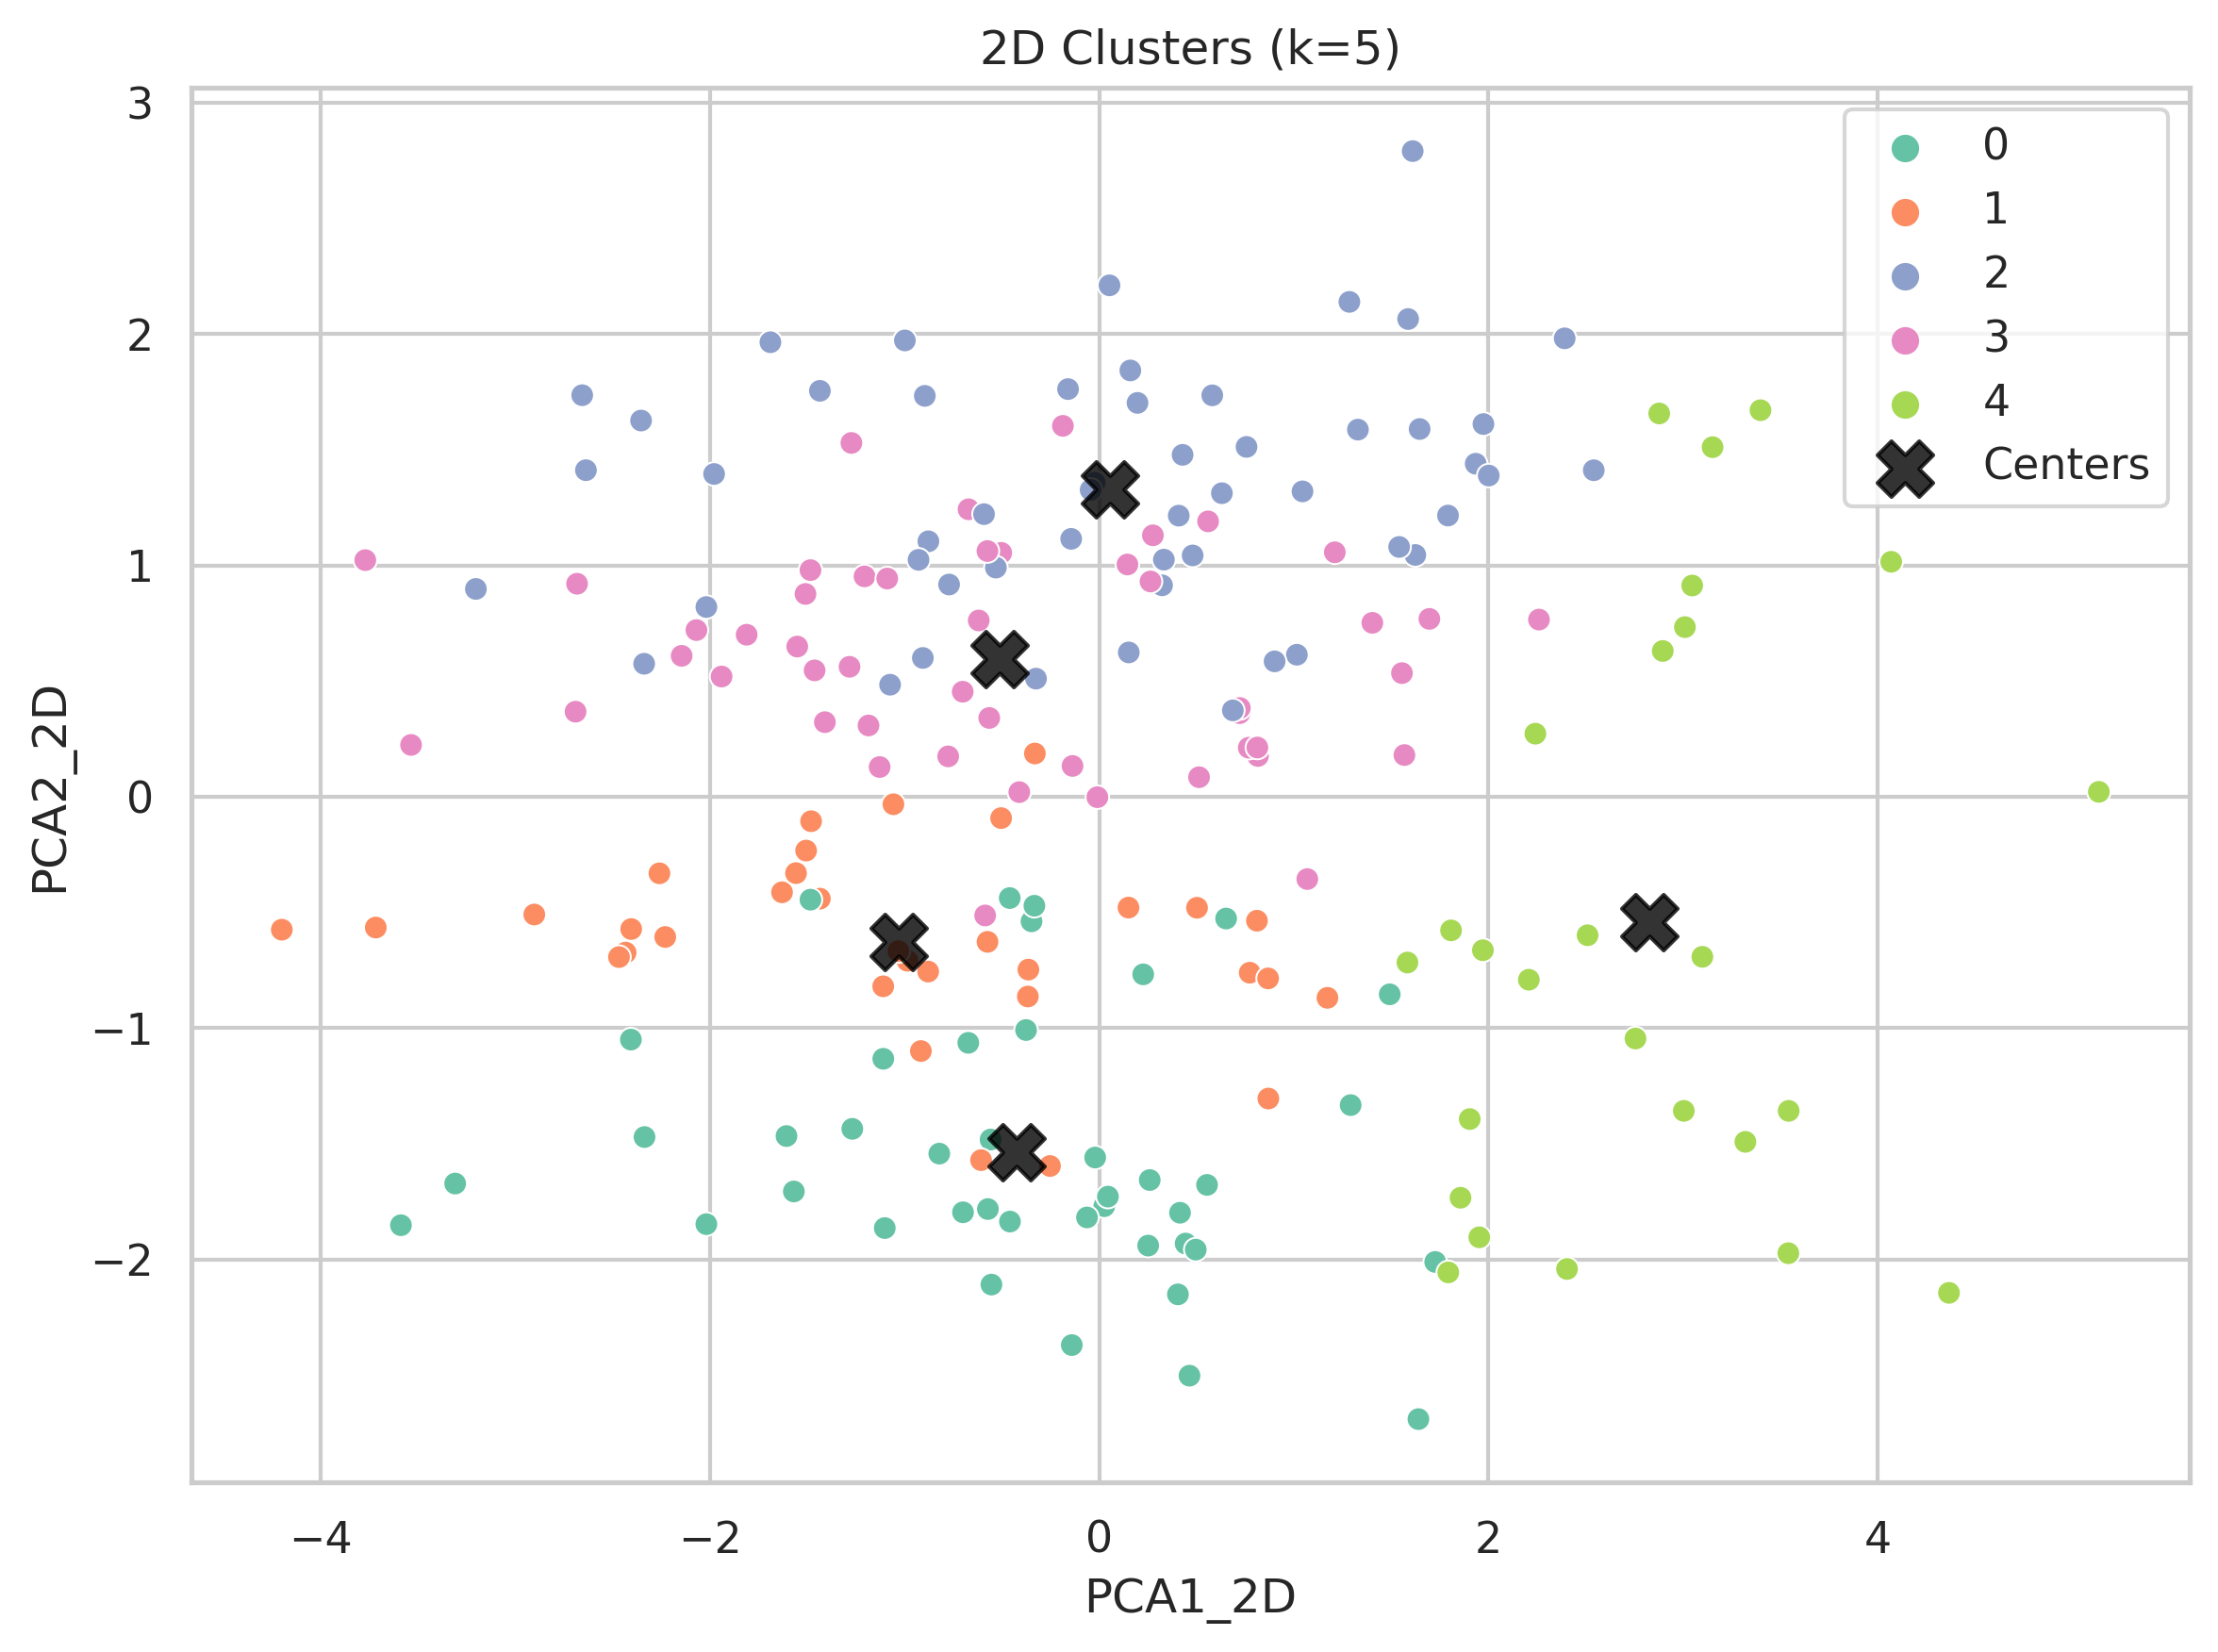

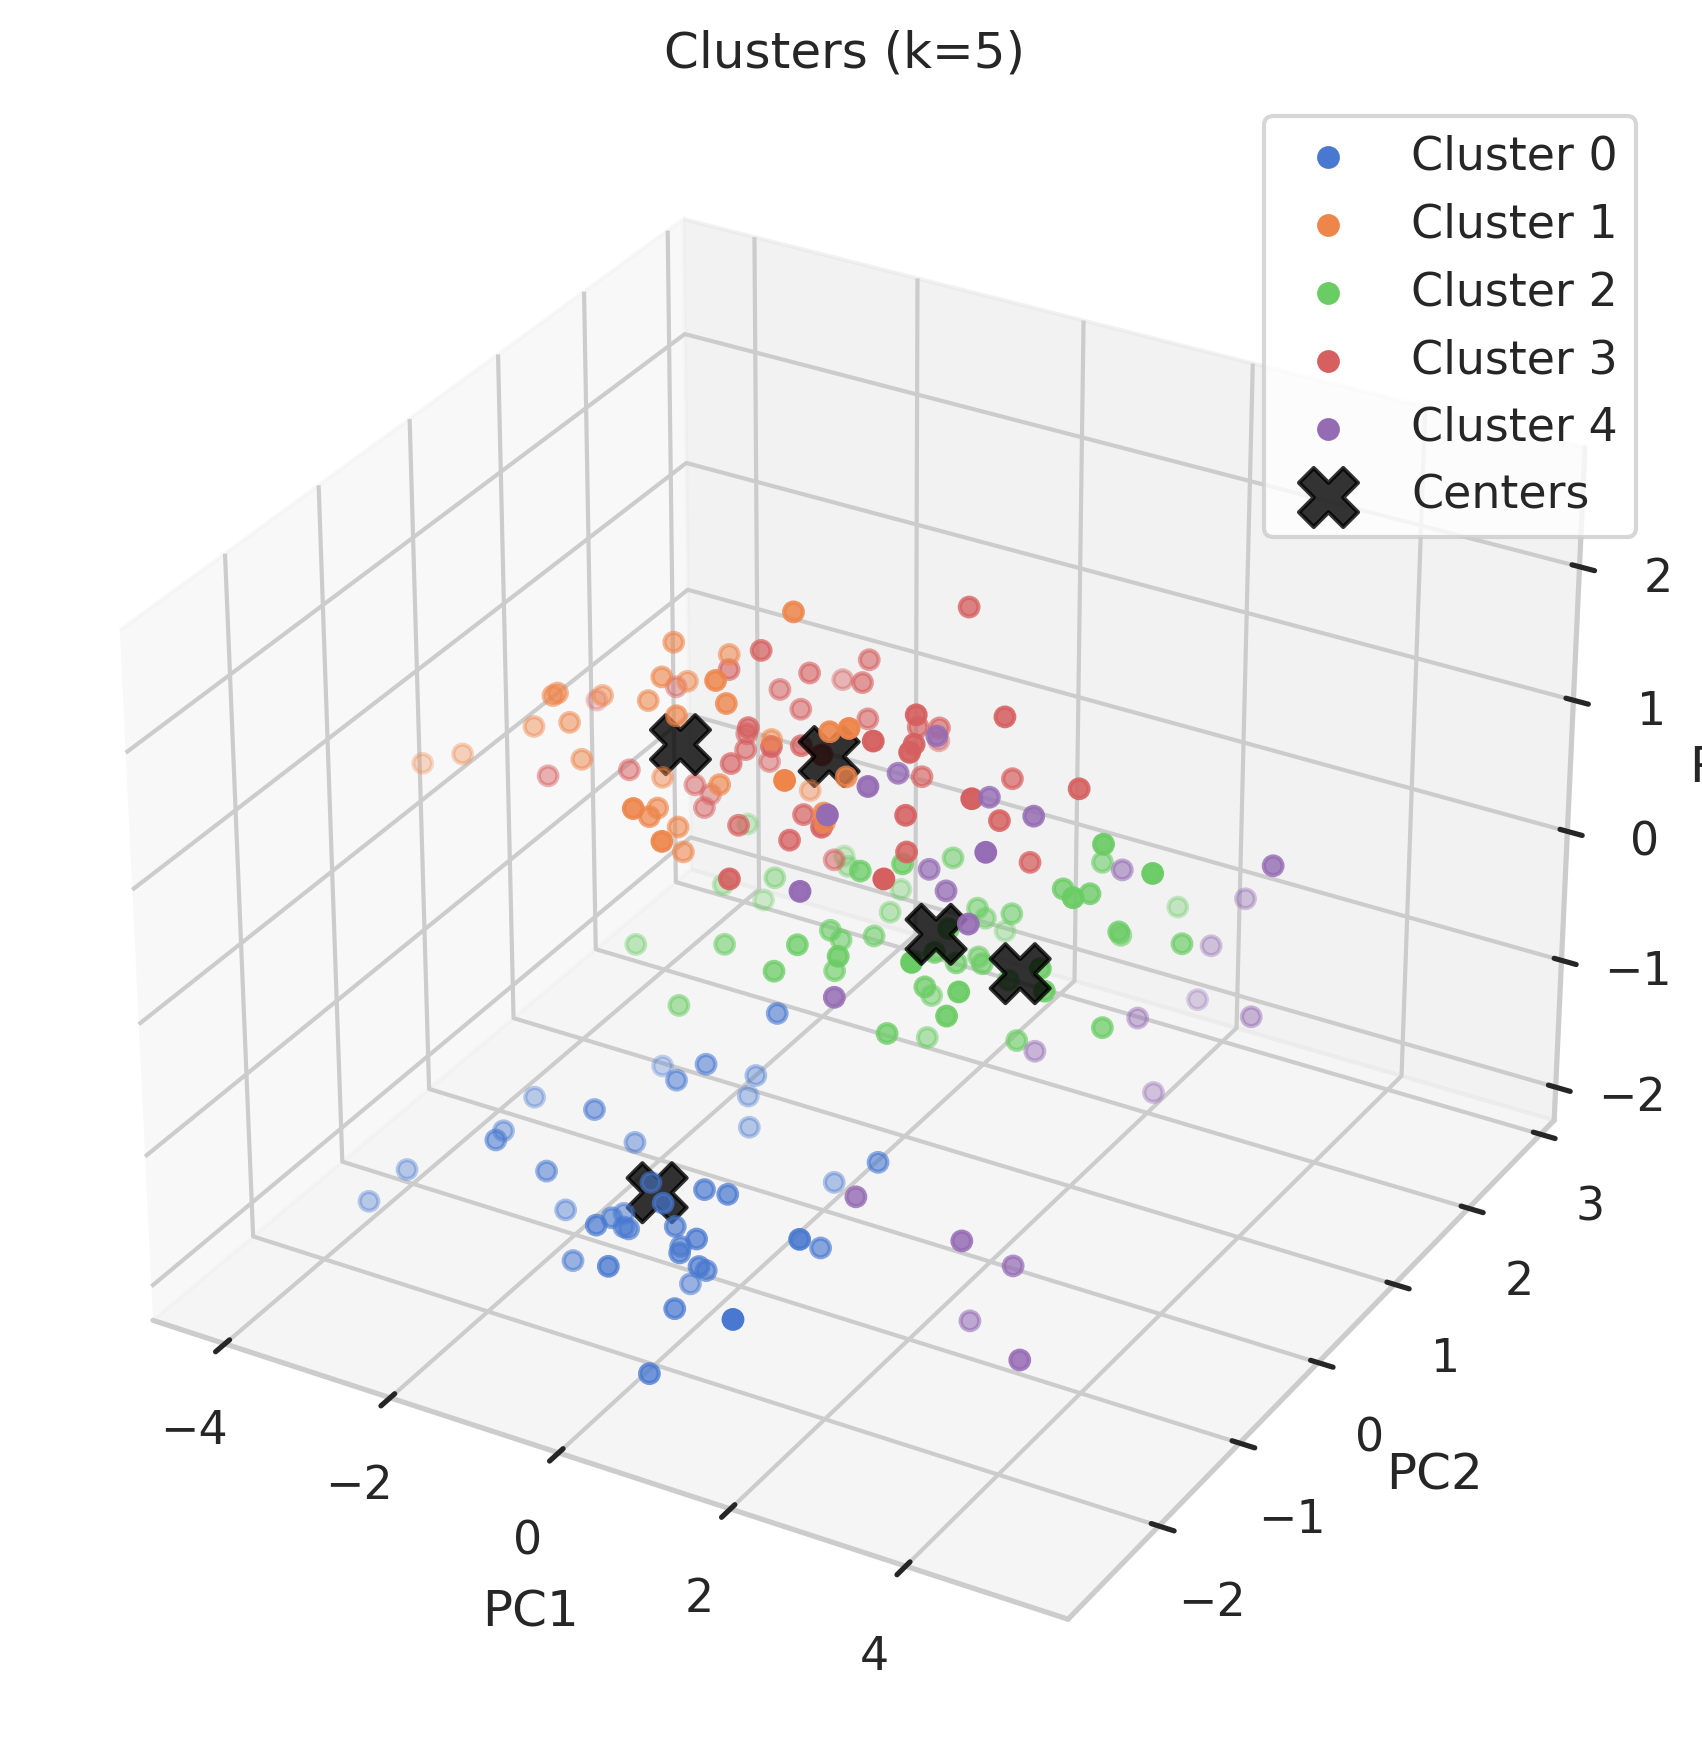

In [42]:
cluster_centers = best_model.cluster_centers_

pca_2d = PCA(n_components=2, random_state=42)
proj_2d = pca_2d.fit_transform(X_scaled)
cust_data['PCA1_2D'] = proj_2d[:,0]
cust_data['PCA2_2D'] = proj_2d[:,1]

center_2d = pca_2d.transform(cluster_centers)

plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1_2D', y='PCA2_2D', hue='ClusterLabel', data=cust_data, palette='Set2')
plt.scatter(center_2d[:,0], center_2d[:,1], c='black', s=200, alpha=0.8, marker='X', label='Centers')
plt.title(f'2D Clusters (k={best_k})')
plt.legend()
plt.tight_layout()
plt.show()

pca_3d = PCA(n_components=3, random_state=42)
proj_3d = pca_3d.fit_transform(X_scaled)
cust_data['PCA1_3D'] = proj_3d[:,0]
cust_data['PCA2_3D'] = proj_3d[:,1]
cust_data['PCA3_3D'] = proj_3d[:,2]

center_3d = pca_3d.transform(cluster_centers)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
for lbl in np.unique(labels_final):
    mask = (labels_final == lbl)
    ax.scatter(proj_3d[mask,0], proj_3d[mask,1], proj_3d[mask,2], label=f'Cluster {lbl}')
ax.scatter(center_3d[:,0], center_3d[:,1], center_3d[:,2], c='black', s=200, marker='X', alpha=0.8, label='Centers')
ax.set_title(f'Clusters (k={best_k})')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend()
plt.tight_layout()
plt.show()

